# Load Model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import os
import torchvision.transforms as transforms
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./PROJECT"), '../..')))
from Models.Util.loadData import create_hanzi_dataloaders

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out 
    
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

Resnet50 = ResNet50()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


test_transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize([0.5], [0.5])
     ])

batch_size = 32

def get_test_loader(batch_size, transform):
    
    testloader = create_hanzi_dataloaders(root_dir="../DDPM/split_img", batch_size=batch_size,preprocess=test_transform)
    return testloader
    
testloader = get_test_loader(batch_size, test_transform)


def accuracy(output, target):
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1]
    return pred.eq(target.view_as(pred)).float().mean()

len(testloader.dataset)

cuda:0


196

In [ ]:
loaded_net = ResNet50()
# load_from_path = './checkpoints/cifar_resnet_with_adamw_acc89.pth'
load_from_path = './checkpoints/resnet50_vae.pth'
def load(net, path):
    net.load_state_dict(torch.load(path))
    
load(loaded_net, load_from_path)

In [70]:
loaded_net.eval()
test_transform = transforms.Compose([
    transforms.ToTensor(),  # 与训练时相同的归一化
])


test_image_folder = '../VAE/latent_space_images'
image_files = [f for f in os.listdir(test_image_folder) if f.endswith(('png', 'jpg', 'jpeg'))]
def predict_single_image(model, device, image_path, transform):
    # 加载图片并进行预处理
    image = Image.open(image_path).convert('L')  # 确保图片是RGB格式
    image = transform(image).unsqueeze(0)  # 预处理并增加批次维度

    # 模型不需要计算梯度
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        max_value, max_index = torch.max(probabilities, 1)
    return max_index.item(), max_value.item()  # 返回预测的类别索引

output_file = 'predictions.txt'

# 遍历所有图片并预测
# for image_file in image_files:
#     image_path = os.path.join(test_image_folder, image_file)
    
#     # 对图片进行预测
#     predicted_label, predicted_prob = predict_single_image(loaded_net, device, image_path, test_transform)
    
#     # 输出图片名称和预测的类别索引
#     print(f"Image: {image_file}, Predicted Label: {predicted_label}, Predicted Probability: {predicted_prob}")
# 打开输出文件
with open(output_file, 'w') as f:
    # 遍历所有图片并进行预测
    for image_file in image_files:
        image_path = os.path.join(test_image_folder, image_file)
        
        # 对图片进行预测
        predicted_label, predicted_prob = predict_single_image(loaded_net, device, image_path, test_transform)
        
        # 假设图片名称格式为 "img_X_Y.png", 提取横坐标和纵坐标
        # 例如: "img_10_20.png" -> 横坐标: 10, 纵坐标: 20
        base_name = os.path.splitext(image_file)[0]  # 去除扩展名
        # 假设文件名格式为 "img_X_Y"
        parts = base_name.split('_')
        
        x_coord = parts[0]  # 横坐标
        y_coord = parts[1]  # 纵坐标
        
        # 写入文件，格式为 "x_coord, y_coord, label, probability"
        f.write(f"{x_coord},{y_coord},{predicted_label},{predicted_prob:.4f}\n")

print(f"Predictions saved to {output_file}")

Predictions saved to predictions.txt


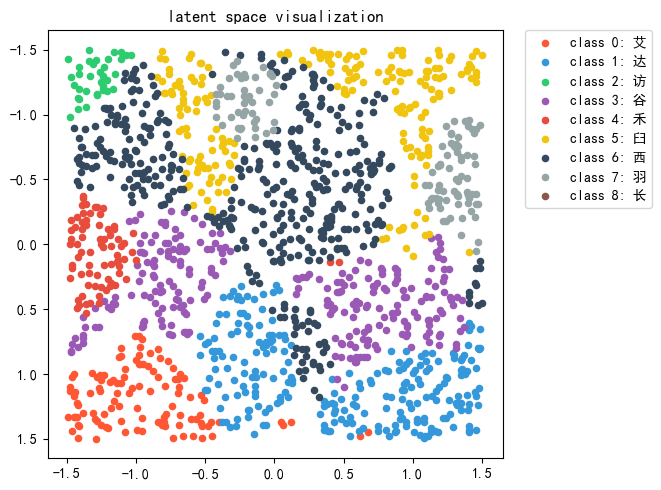

In [83]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

# 设置字体为 SimHei（黑体），以支持中文显示
rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 读取数据文件
data_file = 'predictions.txt'

# 初始化存储数据的列表
x_coords = []
y_coords = []
labels = []
probabilities = []
clazz = ['艾', '达', '访', '谷', '禾', '臼', '西', '羽', '长']

# 读取文件并解析数据
with open(data_file, 'r') as file:
    for line in file:
        x, y, label, prob = line.strip().split(',')
        x = float(x)
        y = float(y)
        label = int(label)
        prob = float(prob)
        
        # 只保留概率大于 0.8 的点
        if prob > 0.45:
            x_coords.append(x)
            y_coords.append(y)
            labels.append(label)
            probabilities.append(prob)

# 使用不同的颜色表示不同的类别
plt.figure(figsize=(8, 5))

# 9 种不同的十六进制颜色
colors = ['#FF5733', '#3498DB', '#2ECC71', '#9B59B6', '#E74C3C', '#F1C40F', '#34495E', '#95A5A6', '#8c564b']

# 遍历每个类别并绘制点
for i in range(9):  # 假设类别是 0 到 8
    # 筛选出属于类别 i 的点
    x_class = [x_coords[j] for j in range(len(labels)) if labels[j] == i]
    y_class = [y_coords[j] for j in range(len(labels)) if labels[j] == i]
    
    # 只绘制该类别的点，使用对应的颜色
    plt.scatter(x_class, y_class, color=colors[i], label=f'class {i}: {clazz[i]}', s=20,)

plt.gca().invert_yaxis()
plt.legend(
    bbox_to_anchor=(1.05, 1),  # 图例放置在右边
    loc='upper left',          # 图例左上角对齐
    borderaxespad=0.           # 图例与绘图区之间的距离
)

plt.title('latent space visualization')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# TEST DDPM

In [22]:
loaded_net = ResNet50()
# load_from_path = './checkpoints/cifar_resnet_with_adamw_acc89.pth'
load_from_path = './checkpoints/resnet50_ddpm.pth'
def load(net, path):
    net.load_state_dict(torch.load(path))
    
load(loaded_net, load_from_path)

In [23]:
def test(net, testloader):
    correct = 0
    total = 0
    net.to(device)
    net.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the DDPM generated test images: %d %%' % (
        100 * correct / total))

test(Resnet50, testloader)

Accuracy of the network on the DDPM generated test images: 0 %


In [17]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# 图像路径
image_path = '../../Dataset/hanzi/processed/艾_0.png'  # 替换为你的图像路径

# 打开图像文件
img = Image.open(image_path)

# 转换为张量
transform = transforms.ToTensor()
img_tensor = transform(img)

# 打印张量的维度和数据
print(f"图像的张量形状: {img_tensor.shape}")
print("图像的张量数据: ")
print(testloader.dataset[0][0][0])

图像的张量形状: torch.Size([1, 32, 32])
图像的张量数据: 
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
        [0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
        [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0039]])
